# 전력수요 및 SMP 예측

## 필요 모듈 import

In [801]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime, timedelta
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

import warnings
warnings.filterwarnings(action='ignore')

## 평가 함수

### 대회 평가 함수

In [2]:
## axis = 0
## weight = [0.1, 0.1, 0.2, 0.6] (smp_max, smp_min, smp_mean, supply에 대한 가중치)

import numpy as np

def rmsse(y_true, y_pred, y_hist, axis = None, weight = None):
    '''
    y_true: 실제 값 
    y_pred: 예측 값
    y_hist: 과거 값 (public LB는 v1 기간으로 계산, private LB는 v2 기간으로 계산)
    '''
    
    y_true, y_pred, y_hist = np.array(y_true), np.array(y_pred), np.array(y_hist)
    
    h, n = len(y_true), len(y_hist)


    numerator = np.sum((y_true - y_pred)**2, axis = axis)
    
    denominator = 1/(n-1)*np.sum((y_hist[1:] - y_hist[:-1])**2, axis = axis)
    
    msse = 1/h * numerator/denominator
    
    rmsse = msse ** 0.5
    
    score = rmsse
    
    if weight is not None:
        
        score = rmsse.dot(weight)
    
    return score

### RMSE 테스트 평가 함수

In [3]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y,pred)
    rmse_val = rmse(y,pred)
    rmsle_val = rmsle(y,pred)
    print('MAE : {0:.3f}, MSE : {1:.3F}, RMSE : {2:.3F}, RMSLE : {3:.3F}'.format(mae_val,mse_val,rmse_val,rmsle_val))

## 전력수요(Supply)와 SMP(계통한계가격)[max,min,mean] 예측에 사용할 Feature 데이터 셋 생성 (2018-01-01 ~ 2020-12-31)

__전력수요(Supply)와 SMP(계통한계가격)[max,min,mean] 예측에 사용할 Feature 추가__  
- v1 데이터
    - 데이터 기간: 2018.02.01 ~ 2020.01.31
    - 목적: 2020.02.07 ~ 2020.03.05 의 전력수요 및 SMP 예측
    
    
- v2 데이터
    - 데이터 기간: 2018.02.01 ~ 2020.05.18
    - 목적: 2020.05.25 ~ 2020.06.21 의 전력수요 및 SMP 예측
    
    
- 최종목적인 2020-05-25 ~ 2020-06-21 예측을 위해 2018-02-01 부터 2020-06-21 까지의 Month, 요일(Day of Week), 1년 중 몇번 째 날인지 (Day of Year), YTT(어제,오늘,내일의 휴일여부) 데이터 생성  

    
- temp_d 데이터에 Feature들 추가
    - Month
    - 요일(Day of Week)
    - 1년중 몇번째 날인지(Day of Year)
    - YTT(어제,오늘,내일 휴일여부)

### 2018-01-01 ~ 2020-12-31 데이터 생성

#### Month, DayofWeek, DayofYear 컬럼 생성

In [426]:
time_data = pd.DataFrame({'datetime':pd.date_range('2018-01-01','2020-12-31', freq='D')})

time_data['month'] = time_data['datetime'].dt.month
time_data['day_of_week'] = time_data['datetime'].dt.dayofweek
time_data['day_of_year'] = time_data['datetime'].dt.dayofyear
time_data

,datetime,month,day_of_week,day_of_year
0,2018-01-01,1,0,1
1,2018-01-02,1,1,2
2,2018-01-03,1,2,3
3,2018-01-04,1,3,4
4,2018-01-05,1,4,5
5,2018-01-06,1,5,6
6,2018-01-07,1,6,7
7,2018-01-08,1,0,8
8,2018-01-09,1,1,9
9,2018-01-10,1,2,10


#### YTT(어제,오늘,내일의 휴일 여부) 컬럼 생성

##### 컬럼생성

In [427]:
time_data['yd'] = 0
time_data['td'] = 0
time_data['tm'] = 0

##### 토,일요일 해당 yt,td,tm 업데이트

In [428]:
# today 휴일 여부 update -> 토, 일
time_data.loc[time_data['datetime'].dt.dayofweek.isin([5,6]) == True, 'td']= 1

# yesterday 휴일 여부 update  -> 일, 8월
time_data.loc[time_data['datetime'].dt.dayofweek.isin([0,6]) == True, 'yd']= 1

# tomorrow 휴일 여부 update -> 금,토
time_data.loc[time_data['datetime'].dt.dayofweek.isin([4,5]) == True, 'tm']= 1

time_data

,datetime,month,day_of_week,day_of_year,yd,td,tm
0,2018-01-01,1,0,1,1,0,0
1,2018-01-02,1,1,2,0,0,0
2,2018-01-03,1,2,3,0,0,0
3,2018-01-04,1,3,4,0,0,0
4,2018-01-05,1,4,5,0,0,1
5,2018-01-06,1,5,6,0,1,1
6,2018-01-07,1,6,7,1,1,0
7,2018-01-08,1,0,8,1,0,0
8,2018-01-09,1,1,9,0,0,0
9,2018-01-10,1,2,10,0,0,0


##### 주말(토,일)을 제외한 공휴일에 해당되는 yd,td,tm 업데이트  
__2018-02-01 ~ 2020-01-31__
- 2018년 
    - 1월 : 1일/월 (신정)
    - 2월 : 15일,16일,17일/목,금,토 (설날)
    - 3월 : 1일/목 (삼일절)
    - 4월 : -
    - 5월 : 5일/토 (어린이날), 7일/월 (어린이날 대체휴일), 22일/화 (석가탄신일)
    - 6월 : 6일/수 (현충일), 13일/수 (지방선거)
    - 7월 : -
    - 8월 : 15일/수 (광복절)
    - 9월 : 23일,24일,25일,26일/일,월,화,수 (추석)
    - 10월 : 3일/수요일 (개천절), 9일/화요일 (한글날)
    - 11월 : -
    - 12월 : 25일/화요일 (크리스마스)
    
    
- 2019년   
    - 1월 : 1일/화 (신정)
    - 2월 : 4일,5일,6일/월,화,수 (설날)
    - 3월 : 1일/금 (삼일절)
    - 4월 : -
    - 5월 : 5일/일 (어린이날), 6일/월 (어린이날 대체휴일), 12일/일 (석가탄신일)
    - 6월 : 6일/목 (현충일)
    - 7월 : - 
    - 8월 : 15일/목 (광복절)
    - 9월 : 12일,13일,14일/목,금,토 (추석)
    - 10월 : 3일/목 (개천절), 9일/수 (한글날)
    - 11월 : -
    - 12월 : 25일/수 (크리스마스)
    
    
- 2020년
    - 1월 : 1일/수 (신정), 24일,25일,26,27/금,토,일,월 (설날)
    - 2월 : -
    - 3월 : 1일/일 (삼일절)
    - 4월 : 15일/수 (총선), 30일/목 (석가탄신일)
    - 5월 : 5일/화 (어린이날)
    - 6월 : 6일/토 (현충일)
    - 7월 : -
    - 8월 : 15일/토 (광복절)
    - 9월 : 30일/수 (추석)
    - 10월 : 1일,2일/목,금 (추석) 3일/토 (개천절), 9일/금 (한글날)
    - 11월 : -
    - 12월 : 25일/금 (크리스마스)

__2018년__

In [429]:
time_data.set_index('datetime', inplace=True)

In [430]:
# 2018-01-01 월 신정
time_data['2018-01-01':'2018-01-01'].td = 1
time_data['2018-01-02':'2018-01-02'].yd = 1

# 2018-02-15~17 목,금,토 설날 전날,당일,내일 값 update
time_data['2018-02-14':'2018-02-14'].tm = 1

time_data['2018-02-15':'2018-02-15'].td = 1
time_data['2018-02-15':'2018-02-15'].tm = 1

time_data['2018-02-16':'2018-02-16'].yd = 1
time_data['2018-02-16':'2018-02-16'].td = 1
time_data['2018-02-16':'2018-02-16'].tm = 1

time_data['2018-02-17':'2018-02-17'].yd = 1

# 2018-03-01 목 삼일절
time_data['2018-02-28':'2018-02-28'].tm = 1
time_data['2018-03-01':'2018-03-01'].td = 1
time_data['2108-03-02':'2018-03-02'].yd = 1

# 2018-05-05 토 어린이날 -> 2018-05-07 월 대체휴일
time_data['2018-05-06':'2018-05-06'].tm = 1
time_data['2018-05-07':'2018-05-07'].td = 1
time_data['2018-05-08':'2018-05-08'].yd = 1

# 2018-05-22 화 석가탄신일
time_data['2018-05-21':'2018-05-21'].tm = 1
time_data['2018-05-22':'2018-05-22'].td = 1
time_data['2018-05-23':'2018-05-23'].yd = 1

# 2018-06-06 수 현충일
time_data['2018-06-05':'2018-06-05'].tm = 1
time_data['2018-06-06':'2018-06-06'].td = 1
time_data['2018-06-07':'2018-06-07'].yd = 1

# 2018-06-13 수 지방선거
time_data['2018-06-12':'2018-06-12'].tm = 1
time_data['2018-06-13':'2018-06-13'].td = 1
time_data['2018-06-14':'2018-06-14'].yd = 1

# 2018-08-15 수 광복절
time_data['2018-08-14':'2018-08-14'].tm = 1
time_data['2018-08-15':'2018-08-15'].td = 1
time_data['2018-08-16':'2018-08-16'].yd = 1

# 2018-09-23 ~ 26 일,월,화,수 추석
time_data['2018-09-23':'2018-09-23'].tm = 1

time_data['2018-09-24':'2018-09-24'].td = 1
time_data['2018-09-24':'2018-09-24'].tm = 1

time_data['2018-09-25':'2018-09-25'].yd = 1
time_data['2018-09-25':'2018-09-25'].td = 1
time_data['2018-09-25':'2018-09-25'].tm = 1

time_data['2018-09-26':'2018-09-26'].yd = 1
time_data['2018-09-26':'2018-09-26'].td = 1
time_data['2018-09-26':'2018-09-26'].tm = 1

time_data['2018-09-27':'2018-09-27'].yd = 1

# 2018-10-03 수 개천절
time_data['2018-10-02':'2018-10-02'].tm = 1
time_data['2018-10-03':'2018-10-03'].td = 1
time_data['2018-10-04':'2018-10-04'].yd = 1

# 2018-10-09 화 한글날
time_data['2018-10-08':'2018-10-08'].tm = 1
time_data['2018-10-09':'2018-10-09'].td = 1
time_data['2018-10-10':'2018-10-10'].yd = 1

# 2018-12-25 화 크리스마스
time_data['2018-12-24':'2018-12-24'].tm = 1
time_data['2018-12-25':'2018-12-25'].td = 1
time_data['2018-12-26':'2018-12-26'].yd = 1


__2019년__

In [431]:
# 2019-01-01 화 신정
time_data['2018-12-31':'2018-12-31'].tm = 1
time_data['2019-01-01':'2019-01-01'].td = 1
time_data['2019-01-02':'2019-01-02'].yd = 1

# 2019-02-04 ~ 06 월,화,수 설날
time_data['2019-02-03':'2019-02-03'].tm = 1

time_data['2019-02-04':'2019-02-04'].td = 1
time_data['2019-02-04':'2019-02-04'].tm = 1

time_data['2019-02-05':'2019-02-05'].yd = 1
time_data['2019-02-05':'2019-02-05'].td = 1
time_data['2019-02-05':'2019-02-05'].tm = 1

time_data['2019-02-06':'2019-02-06'].yd = 1
time_data['2019-02-06':'2019-02-06'].td = 1

time_data['2019-02-07':'2019-02-07'].yd = 1

# 2019-03-01 금 삼일절
time_data['2019-02-28':'2019-02-28'].tm = 1
time_data['2019-03-01':'2019-03-01'].td = 1
time_data['2019-03-02':'2019-03-02'].yd = 1

# 2019-05-05 일 어린이날 -> 2019-05-06 월 대체휴일
time_data['2019-05-05':'2019-05-05'].tm = 1
time_data['2019-05-06':'2019-05-06'].td = 1
time_data['2019-05-07':'2019-05-07'].yd = 1

# 2019-05-22 일 석가탄신일 업데이트 불필요

# 2019-06-06 목 현충일
time_data['2019-06-05':'2019-06-05'].tm = 1
time_data['2019-06-06':'2019-06-06'].td = 1
time_data['2019-06-07':'2019-06-07'].yd = 1

# 2019-08-15 목 광복절
time_data['2019-08-14':'2019-08-14'].tm = 1
time_data['2019-08-15':'2019-08-15'].td = 1
time_data['2019-08-16':'2019-08-16'].yd = 1

# 2019-09-12 ~ 14 목,금,토 추석
time_data['2019-09-11':'2019-09-11'].tm = 1

time_data['2019-09-12':'2019-09-12'].td = 1
time_data['2019-09-12':'2019-09-12'].tm = 1

time_data['2019-09-13':'2019-09-13'].yd = 1
time_data['2019-09-13':'2019-09-13'].td = 1
time_data['2019-09-13':'2019-09-13'].tm = 1

time_data['2019-09-14':'2019-09-14'].yd = 1

# 2019-10-03 목 개천절
time_data['2019-10-02':'2019-10-03'].tm = 1
time_data['2019-10-03':'2019-10-03'].td = 1
time_data['2019-10-04':'2019-10-04'].yd = 1

# 2019-10-09 수 한글날
time_data['2019-10-08':'2019-10-08'].tm = 1
time_data['2019-10-09':'2019-10-09'].td = 1
time_data['2019-10-10':'2019-10-10'].yd = 1

# 2019-12-25 수 크리스마스
time_data['2019-12-24':'2019-12-24'].tm = 1
time_data['2019-12-25':'2019-12-25'].td = 1
time_data['2019-12-26':'2019-12-26'].yd = 1


__2020년__

In [432]:
# 2020-01-01 화 신정
time_data['2019-12-31':'2019-12-31'].tm = 1
time_data['2020-01-01':'2020-01-01'].td = 1
time_data['2020-01-02':'2020-01-02'].yd = 1

# 2020-01-24 ~ 27 금,토,일,월 설날
time_data['2020-01-23':'2020-01-23'].tm = 1

time_data['2020-01-24':'2020-01-24'].td = 1

time_data['2020-01-25':'2020-01-25'].yd = 1

time_data['2020-01-26':'2020-01-26'].tm = 1

time_data['2020-01-27':'2020-01-27'].td = 1

time_data['2020-01-28':'2020-01-28'].yd = 1

# 2020-03-01 일 삼일절 업데이트 불필요

# 2020-04-15 수 총선
time_data['2020-04-14':'2020-04-14'].tm = 1
time_data['2020-04-15':'2020-04-15'].td = 1
time_data['2020-04-16':'2020-04-16'].yd = 1

# 2020-04-30 목 석가탄신일
time_data['2020-04-29':'2020-04-29'].tm = 1
time_data['2020-04-30':'2020-04-30'].td = 1
time_data['2020-05-01':'2020-05-01'].yd = 1

# 2020-05-05 화 어린이날
time_data['2020-05-04':'2020-05-04'].tm = 1
time_data['2020-05-05':'2020-05-05'].td = 1
time_data['2020-05-06':'2020-05-06'].yd = 1

# 2020-06-06 토 현충일 업데이트 불필요

# 2019-08-15 토 광복절 업데이트 불필요

# 2020-09-30 ~ 2020-10-02 수,목,금 추석
time_data['2020-09-29':'2020-09-29'].tm = 1

time_data['2020-09-30':'2020-09-30'].td = 1
time_data['2020-09-30':'2020-09-30'].tm = 1

time_data['2020-10-01':'2020-10-01'].yd = 1
time_data['2020-10-01':'2020-10-01'].td = 1
time_data['2020-10-01':'2020-10-01'].tm = 1

time_data['2020-10-02':'2020-10-02'].yd = 1
time_data['2020-10-02':'2020-10-02'].td = 1

time_data['2020-10-03':'2020-10-03'].yd = 1

# 2020-10-03 토 개천절 업데이트 불필요

# 2020-10-09 금 한글날
time_data['2020-10-08':'2020-10-08'].tm = 1
time_data['2020-10-09':'2020-10-09'].td = 1
time_data['2020-10-10':'2020-10-10'].yd = 1

# 2020-12-25 금 크리스마스
time_data['2020-12-24':'2020-12-24'].tm = 1
time_data['2020-12-25':'2020-12-25'].td = 1
time_data['2020-12-26':'2020-12-26'].yd = 1

# 2020-12-31 목 2021-01-01 신정 전날 
time_data['2020-12-31':'2020-12-31'].tm = 1

##### yd, td, tm -> ytt 하나의 컬럼으로 병합

In [433]:
time_data.reset_index(inplace=True)
time_data['ytt'] = time_data[['yd', 'td', 'tm']].apply(lambda x: ''.join(x.astype(str)), axis=1)
time_data = time_data[['datetime','month','day_of_week','day_of_year','ytt']]
time_data

,datetime,month,day_of_week,day_of_year,ytt
0,2018-01-01,1,0,1,110
1,2018-01-02,1,1,2,100
2,2018-01-03,1,2,3,000
3,2018-01-04,1,3,4,000
4,2018-01-05,1,4,5,001
5,2018-01-06,1,5,6,011
6,2018-01-07,1,6,7,110
7,2018-01-08,1,0,8,100
8,2018-01-09,1,1,9,000
9,2018-01-10,1,2,10,000


##### 명목형 변수 type 카테고리 변경

In [80]:
# 범주형 feature의 type을 category로 변경 해 준다.
time_data['month'] = time_data['month'].astype('category')
time_data['day_of_week'] = time_data['day_of_week'].astype('category')
time_data['day_of_year'] = time_data['day_of_year'].astype('category')
time_data['ytt'] = time_data['ytt'].astype('category')

print(time_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
datetime       1096 non-null datetime64[ns]
month          1096 non-null category
day_of_week    1096 non-null category
day_of_year    1096 non-null category
ytt            1096 non-null category
dtypes: category(4), datetime64[ns](1)
memory usage: 28.0 KB
None


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

#### time_data csv 저장

In [ ]:
time_data = pd.get_dummies(time_data, columns=['month','day_of_week','day_of_year','ytt'])

## 데이터 로드 및 정제 & 모델생성 및 평가

### 기상정보 관측 지점 명

In [3]:
area = pd.read_csv('data/SMP/lookupTable_area.csv')
area.head()

,area,name
0,184,제주
1,185,고산
2,188,성산
3,189,서귀포
4,328,중문


### smp_i_d (일별 smp_max, smp_min, smp_mean, supply)  
최종적으로 예측해야 할 target 값.  
v1 : 2018-02-01 ~ 2020-01-31  
v2 : 2018-02-01 ~ 2020-05-18

In [4]:
smp_i_d1 = pd.read_csv('data/SMP/target_v1.csv', index_col='date',parse_dates=['date'])
smp_i_d2 = pd.read_csv('data/SMP/target_v2.csv', index_col='date',parse_dates=['date'])

smp_i_d = pd.concat([smp_i_d1, smp_i_d2['2020-02-01':]])
smp_i_d

,smp_max,smp_min,smp_mean,supply
date,,,,
2018-02-01,150.65,116.84,132.71,87.47
2018-02-02,163.86,116.84,134.19,86.64
2018-02-03,164.07,116.85,131.39,88.28
2018-02-04,171.00,115.76,131.89,86.14
2018-02-05,170.34,123.89,137.96,90.63
2018-02-06,167.99,119.11,140.06,91.18
2018-02-07,141.07,124.11,132.76,90.09
2018-02-08,147.42,116.84,132.91,87.57
2018-02-09,150.70,116.84,126.95,81.63


### smp_i_t (시간대별 smp)  
v1 : 2018-02-01 ~ 2020-01-31  
v2 : 2018-02-01 ~ 2020-05-18

#### smp_i_t 정제

시간대별 기상정보와 시간대 구성에 차이가 있음.  
  
시간대별 기상정보의 datetime : 2018-02-02 00:00  
시간대별 SMP datetime : 2018-02-01 24:00

In [3]:
smp_i_t = pd.read_csv('data/SMP/hourly_smp_v1.csv')
smp_i_t['datetime'] = smp_i_t['datetime'].apply(lambda x : pd.to_datetime(x[:10] + ' {:02d}:00:00'.format(int(x[11:13])-1)))
smp_i_t.set_index('datetime', inplace=True)
smp_i_t

,smp
datetime,
2018-02-01 00:00:00,116.84
2018-02-01 01:00:00,116.84
2018-02-01 02:00:00,116.84
2018-02-01 03:00:00,116.84
2018-02-01 04:00:00,116.84
2018-02-01 05:00:00,116.84
2018-02-01 06:00:00,116.84
2018-02-01 07:00:00,116.84
2018-02-01 08:00:00,146.87


### ★ 기상정보

#### 데이터 로드

In [2056]:
weather = pd.read_csv('data/SMP/weather_v1.csv')

__기상정보 관측 지역 개수__

In [2057]:
len(weather['area'].value_counts())

39

__결측확인__

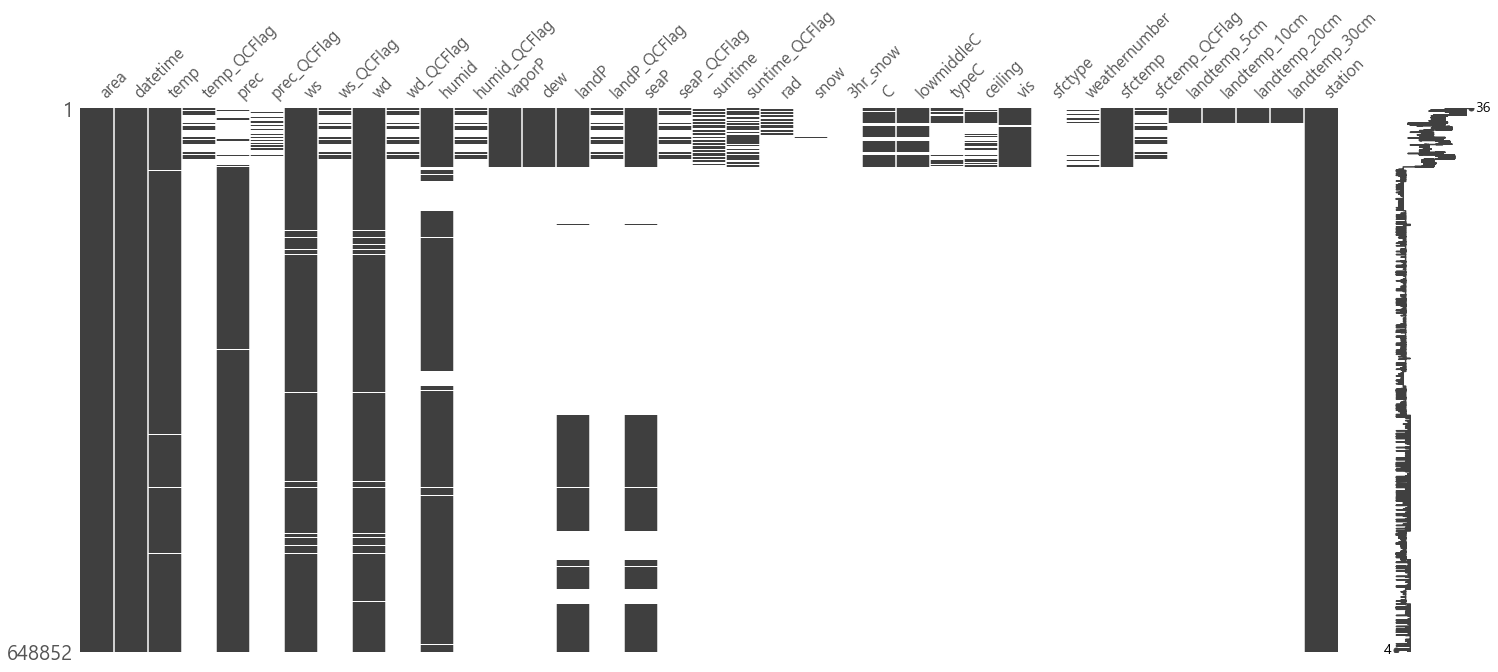

In [2058]:
msno.matrix(weather)

#### 강수,습도,풍속이 SMP와 관련이 있는지 탐색

__강수, 습도, 풍속 결측을 제거하여 추출__

In [2059]:
print(weather['prec'].isna().sum())
print(weather['humid'].isna().sum())
print(weather['ws'].isna().sum())

67438
62607
8335


In [242]:
prec = weather[['prec']].dropna()
humd = weather[['humid']].dropna()
wind = weather[['ws']].dropna()

__시간대별 SMP와 merge 하여 상관도 확인__

In [248]:
prec_smp = pd.merge(prec,SMP,how='left',left_index=True, right_index=True)
humd_smp = pd.merge(humd,SMP,how='left',left_index=True, right_index=True)
wind_smp = pd.merge(wind,SMP,how='left',left_index=True, right_index=True)

In [251]:
print(prec_smp.corr())
print(humd_smp.corr())
print(wind_smp.corr())

          prec       smp
prec  1.000000  0.008811
smp   0.008811  1.000000
          humid       smp
humid  1.000000  0.102733
smp    0.102733  1.000000
           ws       smp
ws   1.000000 -0.058538
smp -0.058538  1.000000


__SMP와 상관도가 가장 높은 습도의 분포 확인__

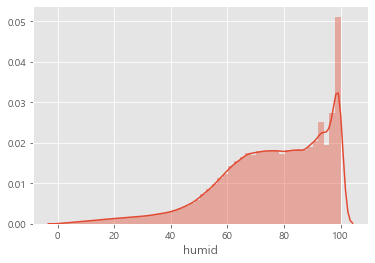

In [258]:
sns.distplot(humd['humid'])

각 기상정보 feature(강수, 습도, 풍속)와 SMP와의 상관도 분석 결과 강수와 픙속은 SMP와 거의 상관이 없고, 습도가 0.1정도의 약한 상관관계가 있는 것으로 확인되었지만, 100에 가까운 의심스러운 수치가 많아 feature로 사용하지 않기로 결정.

#### 기온, 이슬점온도만 사용

__기상정보 데이터에서 기온만 추출__  
전국적으로 공식으로 인정받는 ASOS에서 관측한 지점의 기온만 사용  
- 제주 : 184
- 고산 : 185
- 성산 : 188
- 서귀포 : 189

In [5]:
# ASOS 관측한 지점 4곳의 area, datetime, temp 데이터 로드
weather = (pd.read_csv('data/SMP/weather_v1.csv', low_memory=False, dtype={
    'area': int,
    'temp_QCFlag': str,
    'prec_QCFlag': str,
    'ws_QCFlag': str,
    'wd_QCFlag': str,
    'humid_QCFlag': str,
    'landP_QCFlag': str,
    'seaP_QCFlag': str,
    'suntime_QCFlag': str,
    'sfctemp_QCFlag': str,
})[['area','datetime','temp','dew','station']])
weather = weather[weather['station'] == 'ASOS'][['area','datetime','temp','dew']].set_index(['area','datetime'])
weather.head()

temp  dew
area datetime                   
184  2018-02-01 01:00   4.7 -2.8
     2018-02-01 02:00   4.8 -3.0
     2018-02-01 03:00   4.8 -1.8
     2018-02-01 04:00   4.5 -2.1
     2018-02-01 05:00   4.5 -2.1

#### temp_i_t (시간대별 기상데이터)

In [12]:
# 비어있는 시간대를 채우기 위해 날짜 시간대 data 생성
dt = pd.DataFrame({'datetime':pd.date_range(start='2018-02-01', end='2020-01-31 23:00:00', freq='H')}).set_index('datetime')

# 생성한 전체 시간대와 지점별 기온 데이터를 병합하여 결측치를 채우고 최종 지점 4곳의 온도 데이터 생성
temp_i_t = dt.copy()
for area in set(weather.index.get_level_values(level=0)):
    temp_i_t = pd.merge(\
                   temp_i_t,\
                   pd.merge(\
                            dt, weather.xs(key=area),
                            how='left',left_index=True, right_index=True\
                           ).fillna(method='bfill'),\
                        how='inner',left_index=True, right_index=True\
                       ).rename(columns={'temp':'temp_'+str(area),'dew':'dew_'+str(area)})

temp_i_t

,temp_184,dew_184,temp_185,dew_185,temp_188,dew_188,temp_189,dew_189
datetime,,,,,,,,
2018-02-01 00:00:00,4.7,-2.8,4.2,-0.9,3.3,-4.4,3.4,2.5
2018-02-01 01:00:00,4.7,-2.8,4.2,-0.9,3.3,-4.4,3.4,2.5
2018-02-01 02:00:00,4.8,-3.0,4.6,-1.0,2.7,-3.8,3.3,2.7
2018-02-01 03:00:00,4.8,-1.8,4.9,-1.5,2.3,-4.2,2.7,1.9
2018-02-01 04:00:00,4.5,-2.1,3.8,0.4,2.5,-3.6,2.9,0.7
2018-02-01 05:00:00,4.5,-2.1,4.2,0.0,1.9,-3.5,2.7,0.2
2018-02-01 06:00:00,4.5,-2.6,4.4,-0.4,2.1,-4.0,2.8,-0.4
2018-02-01 07:00:00,4.7,-1.7,4.7,-2.6,1.1,-4.5,2.6,-0.3
2018-02-01 08:00:00,4.5,-2.6,4.8,0.1,1.1,-4.3,2.9,-1.8


In [14]:
# 지점 4곳의 기온,이슬점온도의 중앙값으로 하나의 시간대별 기온, 이슬점온도 데이터 생성
temp_i_t['temp'] = temp_i_t[['temp_184', 'temp_185', 'temp_188', 'temp_189']].median(axis=1)
temp_i_t['dew'] = temp_i_t[['dew_184', 'dew_185', 'dew_188', 'dew_189']].median(axis=1)
temp_i_t = temp_i_t[['temp','dew']]
temp_i_t

,temp,dew
datetime,,
2018-02-01 00:00:00,3.80,-1.85
2018-02-01 01:00:00,3.80,-1.85
2018-02-01 02:00:00,3.95,-2.00
2018-02-01 03:00:00,3.75,-1.65
2018-02-01 04:00:00,3.35,-0.85
2018-02-01 05:00:00,3.45,-1.05
2018-02-01 06:00:00,3.60,-1.50
2018-02-01 07:00:00,3.65,-2.15
2018-02-01 08:00:00,3.70,-2.20


#### temp_groupby_date (시간대별 기상데이터를 일자별 데이터로 만들기)

__2018 ~ 2020 시간대별 month, day_of_week, day_of_year, ytt Feature 데이터 로드__

In [10]:
time_data = pd.read_csv('data/SMP/2018-2020_time_data.csv',parse_dates=['datetime'], dtype={'ytt':str})

time_data['month'] = time_data['month'].astype('category')
time_data['day_of_week'] = time_data['day_of_week'].astype('category')
time_data['day_of_year'] = time_data['day_of_year'].astype('category')
time_data['ytt'] = time_data['ytt'].astype('category')

time_data.info()
time_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
datetime       1096 non-null datetime64[ns]
month          1096 non-null category
day_of_week    1096 non-null category
day_of_year    1096 non-null category
ytt            1096 non-null category
dtypes: category(4), datetime64[ns](1)
memory usage: 28.0 KB


,datetime,month,day_of_week,day_of_year,ytt
0,2018-01-01,1,0,1,110
1,2018-01-02,1,1,2,100
2,2018-01-03,1,2,3,000
3,2018-01-04,1,3,4,000
4,2018-01-05,1,4,5,001


__1일 변화, 2일 누적변화, 3일 누적변화랑 컬럼 추가 함수__

In [11]:
def add_diff_columns(df, column_name):
    diff_1 = df[column_name] - df[column_name].shift(1)
    diff_1[0] = diff_1[1]
    diff_2 = diff_1 + diff_1.shift(1)
    diff_2[0] = diff_2[1]
    diff_3 = diff_2 + diff_1.shift(2)
    diff_3[0] = diff_3[2]
    diff_3[1] = diff_3[2]
    df[column_name+'_diff_1'] = diff_1
    df[column_name+'_diff_2'] = diff_2
    df[column_name+'_diff_3'] = diff_3
    return df

__temp_d 생성 함수__

In [12]:
# 함수 생성
def temp_groupby_date(temp_t):
    
    temp_d = temp_t.resample('1D').mean().reset_index()

    temp_d['temp_min'] = temp_t.resample('1D').min()['temp'].values
    temp_d['temp_max'] = temp_t.resample('1D').max()['temp'].values
    #temp_d['temp_diff'] = temp_d['temp_max']-temp_d['temp_min']
    
    temp_d['dew_min'] = temp_t.resample('1D').min()['dew'].values
    temp_d['dew_max'] = temp_t.resample('1D').max()['dew'].values
    temp_d = temp_d[['datetime','temp','temp_min','temp_max','dew','dew_min','dew_max']]

    temp_d = pd.merge(temp_d,time_data, left_on='datetime',right_on='datetime', how='left').set_index('datetime')

    temp_d = add_diff_columns(temp_d, 'temp')
    temp_d = add_diff_columns(temp_d, 'temp_min')
    temp_d = add_diff_columns(temp_d, 'temp_max')
    
    temp_d = add_diff_columns(temp_d, 'dew')
    temp_d = add_diff_columns(temp_d, 'dew_min')
    temp_d = add_diff_columns(temp_d, 'dew_max')

    return temp_d


#### temp_i_d (일자별로 재생성된 기상데이터에 시계열 Feature가 join된 최종 예측에 사용될 데이터셋)

In [15]:
temp_i_d = temp_groupby_date(temp_i_t)
temp_i_d

,temp,temp_min,temp_max,dew,dew_min,dew_max,month,day_of_week,day_of_year,ytt,...,temp_max_diff_3,dew_diff_1,dew_diff_2,dew_diff_3,dew_min_diff_1,dew_min_diff_2,dew_min_diff_3,dew_max_diff_1,dew_max_diff_2,dew_max_diff_3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-01,4.270833,3.30,5.95,-2.985417,-4.80,-0.85,2,3,32,000,...,-2.65,-1.727083,-3.454167,-2.885417,-1.90,-3.80,-3.500000e+00,-2.35,-4.70,-2.50
2018-02-02,3.554167,2.45,5.25,-4.712500,-6.70,-3.20,2,4,33,001,...,-2.65,-1.727083,-3.454167,-2.885417,-1.90,-3.80,-3.500000e+00,-2.35,-4.70,-2.50
2018-02-03,1.433333,-0.50,4.00,-4.143750,-6.40,-1.00,2,5,34,011,...,-2.65,0.568750,-1.158333,-2.885417,0.30,-1.60,-3.500000e+00,2.20,-0.15,-2.50
2018-02-04,-1.010417,-2.05,0.30,-5.410417,-7.05,-3.35,2,6,35,110,...,-5.65,-1.266667,-0.697917,-2.425000,-0.65,-0.35,-2.250000e+00,-2.35,-0.15,-2.50
2018-02-05,0.002083,-1.70,2.05,-4.722917,-7.20,-1.75,2,0,36,100,...,-3.20,0.687500,-0.579167,-0.010417,-0.15,-0.80,-5.000000e-01,1.60,-0.75,1.45
2018-02-06,-0.883333,-1.50,-0.20,-5.152083,-8.10,-3.15,2,1,37,000,...,-4.20,-0.429167,0.258333,-1.008333,-0.90,-1.05,-1.700000e+00,-1.40,0.20,-2.15
2018-02-07,0.495833,-1.40,2.30,-3.870833,-5.15,-2.05,2,2,38,000,...,2.00,1.281250,0.852083,1.539583,2.95,2.05,1.900000e+00,1.10,-0.30,1.30
2018-02-08,2.652083,-0.15,6.10,-1.068750,-5.15,1.85,2,3,39,000,...,4.05,2.802083,4.083333,3.654167,0.00,2.95,2.050000e+00,3.90,5.00,3.60
2018-02-09,6.264583,3.30,9.90,0.104167,-1.80,1.50,2,4,40,001,...,10.10,1.172917,3.975000,5.256250,3.35,3.35,6.300000e+00,-0.35,3.55,4.65


#### temp_i_t_f (기온 예측용)

In [146]:
temp_i_t_f = temp_i_t.reset_index()
temp_i_t_f['month'] = temp_i_t_f['datetime'].dt.month
temp_i_t_f['hour'] = temp_i_t_f['datetime'].dt.hour
temp_i_t_f['day_of_year'] = temp_i_t_f['datetime'].dt.dayofyear

temp_i_t_f['month'] = temp_i_t_f['month'].astype('category')
temp_i_t_f['hour'] = temp_i_t_f['hour'].astype('category')
temp_i_t_f['day_of_year'] = temp_i_t_f['day_of_year'].astype('category')
temp_i_t_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
datetime       17520 non-null datetime64[ns]
temp           17520 non-null float64
month          17520 non-null category
hour           17520 non-null category
day_of_year    17520 non-null category
dtypes: category(3), datetime64[ns](1), float64(1)
memory usage: 356.3 KB


__2020.05.25 ~ 2020.06.21 기온 데이터 생성__

In [413]:
temp_itf = pd.DataFrame({'datetime':pd.date_range('2020-05-25','2020-06-21 23:00:00',freq='H')})
temp_itf['month'] = temp_itf['datetime'].dt.month
temp_itf['hour'] = temp_itf['datetime'].dt.hour
temp_itf['day_of_year'] = temp_itf['datetime'].dt.dayofyear

temp_itf['month'] = temp_itf['month'].astype('category')
temp_itf['hour'] = temp_itf['hour'].astype('category')
temp_itf['day_of_year'] = temp_itf['day_of_year'].astype('category')
temp_itf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 4 columns):
datetime       672 non-null datetime64[ns]
month          672 non-null category
hour           672 non-null category
day_of_year    672 non-null category
dtypes: category(3), datetime64[ns](1)
memory usage: 9.7 KB


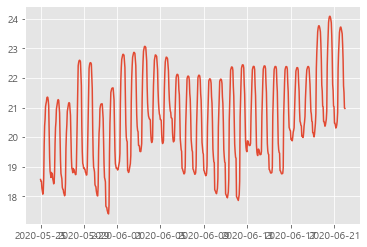

In [418]:
temp_pt = pd.DataFrame({'datetime':pd.date_range('2020-05-25','2020-06-21 23:00:00',freq='H')})
temp_pt['temp'] = temp_rf_model.predict(temp_itf[['month','hour','day_of_year']])
plt.plot(temp_pt.set_index('datetime'))

In [434]:
temp_pd = temp_groupby_date(temp_pt.set_index('datetime'))
temp_pd

,temp_min,temp_max,temp_mean,temp_median,month,day_of_week,day_of_year,ytt,temp_min_diff_1,temp_min_diff_2,temp_min_diff_3,temp_max_diff_1,temp_max_diff_2,temp_max_diff_3,temp_mean_diff_1,temp_mean_diff_2,temp_mean_diff_3,temp_median_diff_1,temp_median_diff_2,temp_median_diff_3
datetime,,,,,,,,,,,,,,,,,,,,
2020-05-25,18.068477,21.352808,19.707741,19.520600,5,0,146,100,0.349574,0.699147,0.295652,-0.085078,-0.170156,-0.273277,0.033112,0.066224,-0.106914,-0.024877,-0.049754,-0.086747
2020-05-26,18.418051,21.267730,19.740853,19.495723,5,1,147,000,0.349574,0.699147,0.295652,-0.085078,-0.170156,-0.273277,0.033112,0.066224,-0.106914,-0.024877,-0.049754,-0.086747
2020-05-27,18.014555,21.164609,19.567715,19.458730,5,2,148,000,-0.403495,-0.053922,0.295652,-0.103121,-0.188199,-0.273277,-0.173138,-0.140026,-0.106914,-0.036993,-0.061870,-0.086747
2020-05-28,18.729006,22.600744,20.378272,19.673417,5,3,149,000,0.714451,0.310955,0.660529,1.436134,1.333013,1.247935,0.810557,0.637419,0.670531,0.214687,0.177693,0.152816
2020-05-29,18.714751,22.518819,20.319739,19.598337,5,4,150,001,-0.014255,0.700195,0.296700,-0.081925,1.354209,1.251088,-0.058533,0.752024,0.578885,-0.075080,0.139607,0.102614
2020-05-30,18.007871,21.127019,19.514250,19.298599,5,5,151,011,-0.706880,-0.721135,-0.006684,-1.391799,-1.473725,-0.037590,-0.805489,-0.864022,-0.053465,-0.299738,-0.374818,-0.160131
2020-05-31,17.400505,21.663454,19.611640,19.497094,5,6,152,110,-0.607366,-1.314245,-1.328501,0.536435,-0.855364,-0.937289,0.097390,-0.708099,-0.766632,0.198495,-0.101243,-0.176323
2020-06-01,18.885742,22.804089,20.864312,20.791050,6,0,153,100,1.485236,0.877871,0.170991,1.140634,1.677070,0.285270,1.252672,1.350062,0.544573,1.293956,1.492451,1.192713
2020-06-02,18.802400,22.869135,20.931555,20.974539,6,1,154,000,-0.083341,1.401895,0.794529,0.065046,1.205681,1.742116,0.067244,1.319916,1.417306,0.183489,1.477445,1.675940


In [435]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd)
    
pred_final_ = pd.DataFrame.from_dict(pred_dict)

In [437]:
pred_final_

,smp_min,smp_max,smp_mean,supply
0,124.652069,172.460809,139.537554,64.627898
1,124.477359,174.665664,139.548881,64.949656
2,125.499002,174.872741,140.076988,64.874159
3,127.859538,174.516133,141.734842,65.698185
4,126.740047,175.691110,140.155802,64.574048
5,123.174914,174.312036,140.052854,62.792394
6,119.726450,174.238860,138.611918,62.887076
7,126.370751,172.522106,141.621179,64.764041
8,126.644348,177.150823,141.608257,65.431486
9,126.786267,181.690219,143.614947,65.909908


In [439]:
pred_final_['date'] = temp_pd.index
pred_final_ = pred_final_[['date','smp_max','smp_min','smp_mean','supply']]
pred_final_.to_csv('2020.05.25-2020.06.21_pred.csv',index=False)
pred_final_

,date,smp_max,smp_min,smp_mean,supply
0,2020-05-25,163.281360,118.361079,137.822421,85.063755
1,2020-05-26,162.713365,117.069898,137.681547,84.404672
2,2020-05-27,160.639372,109.502101,136.646636,83.585025
3,2020-05-28,160.452380,113.404105,132.910620,78.769614
4,2020-05-29,159.012403,111.418882,130.398454,77.560746
5,2020-05-30,149.987446,112.193771,126.877959,73.809088
6,2020-05-31,164.903850,110.594898,132.983049,76.166874
7,2020-06-01,166.805955,117.302340,135.075259,72.307575
8,2020-06-02,153.955217,115.891817,132.215261,66.002992
9,2020-06-03,157.913072,109.091194,132.518556,80.847676


#### temp_i_t_f 로 temp_p_t 예측

__기온 예측모델 생성 함수__

In [324]:
def temp_predict_model(temp_feature):

#temp = temp_i_d.copy()
#smp = smp_i_d.copy()
#target_col = 'smp_mean'

    X_data = temp_feature.drop(['datetime','temp'], axis=1, inplace=False)
    y_target = temp_feature['temp']

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=127)

    params = [{'n_estimators' : [10,50,100,400,800],
              'max_depth' : [6,8,10,12],
              'min_samples_leaf' : [6,8,12],
              'min_samples_split' : [4,8,16]
              }]

    rf_model = RandomForestRegressor()
    cv = KFold(n_splits=5, random_state=12)
    
    gscv = GridSearchCV(rf_model, params, cv=cv, scoring = 'neg_mean_squared_error')
    gscv.fit(X_train, y_train)
    
    best_rf_model = gscv.best_estimator_
    
    best_rf_model.fit(X_train,y_train)
    pred = best_rf_model.predict(X_test)
    
    evaluate_regr(y_test,pred)
    
    return best_rf_model

In [388]:
test = temp_i_t_f[['month','hour','day_of_year']]

In [389]:
temp_rf_model = temp_predict_model(temp_i_t_f)

pred = temp_rf_model.predict(test)

evaluate_regr(temp_i_t_f['temp'],pred)

MAE : 1.561, MSE : 4.371, RMSE : 2.091, RMSLE : 0.215
MAE : 1.458, MSE : 3.731, RMSE : 1.932, RMSLE : INF


In [327]:
pred = temp_rf_model.predict(test)
evaluate_regr(temp_i_t_f['temp'],pred)

MAE : 1.458, MSE : 3.731, RMSE : 1.932, RMSLE : INF


In [203]:
rf_model = RandomForestRegressor(n_estimators = 100, max_features=3)

rf_model.fit(X_train, y_train)
pred = rf_model.predict(test)

evaluate_regr(temp_i_t_f['temp'],pred)

MAE : 1.398, MSE : 4.049, RMSE : 2.012, RMSLE : INF


In [381]:
pred = temp_rf_model.predict(test)
evaluate_regr(temp_i_t_f['temp'],pred)

MAE : 1.458, MSE : 3.731, RMSE : 1.932, RMSLE : INF


In [382]:
temp_i_t_t = temp_i_t_f.set_index('datetime')
temp_i_t_t['pred']=pred

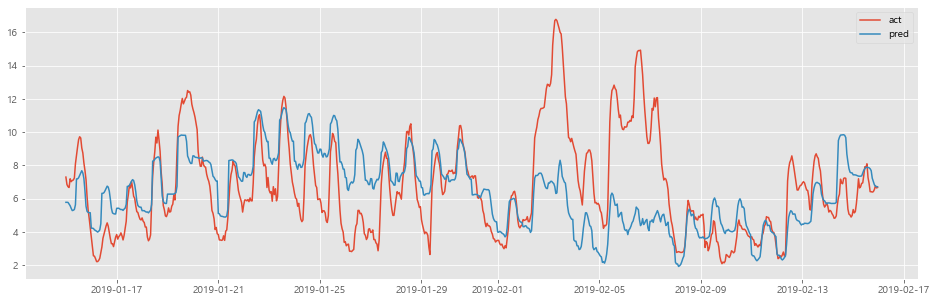

In [383]:
plt.figure(figsize=(16,5))
plt.plot(temp_i_t_t['2019-01-15':'2019-02-15']['temp'])
plt.plot(temp_i_t_t['2019-01-15':'2019-02-15']['pred'])
plt.legend(['act','pred'])

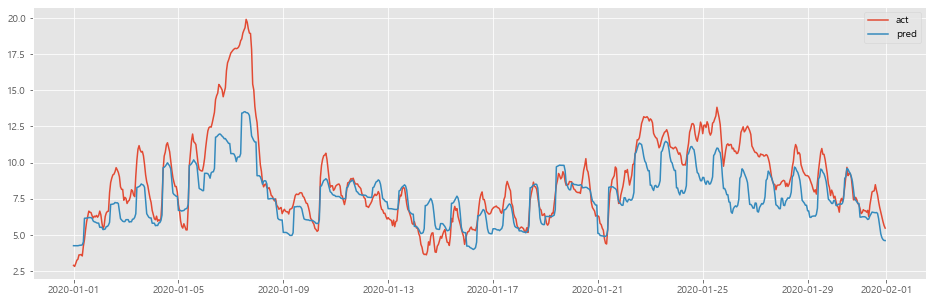

In [387]:
plt.figure(figsize=(16,5))
plt.plot(temp_i_t_t['2020']['temp'])
plt.plot(temp_i_t_t['2020']['pred'])
plt.legend(['act','pred'])

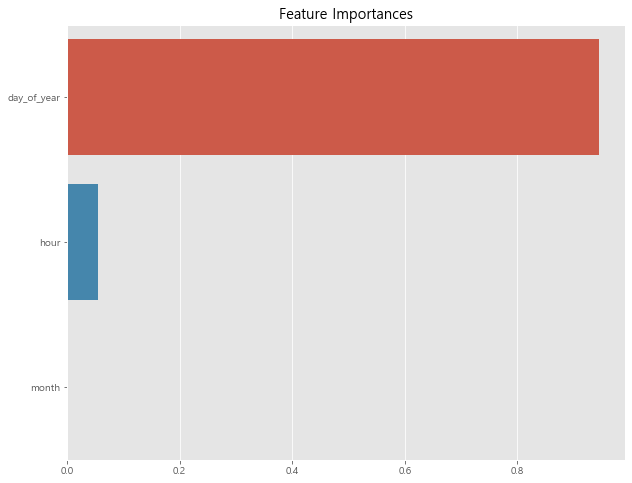

In [152]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

#### temp_r_t_f

__2020-02-01 ~ 2020-05-16__

In [160]:
# ASOS 관측한 지점 4곳의 area, datetime, temp 데이터 로드
weather = (pd.read_csv('data/SMP/weather_v2.csv', low_memory=False, dtype={
    'area': int,
    'temp_QCFlag': str,
    'prec_QCFlag': str,
    'ws_QCFlag': str,
    'wd_QCFlag': str,
    'humid_QCFlag': str,
    'landP_QCFlag': str,
    'seaP_QCFlag': str,
    'suntime_QCFlag': str,
    'sfctemp_QCFlag': str,
})[['area','datetime','temp','station']])
weather = weather[weather['station'] == 'ASOS'][['area','datetime','temp']].set_index(['area','datetime'])

# 비어있는 시간대를 채우기 위해 날짜 시간대 data 생성
dt = pd.DataFrame({'datetime':pd.date_range(start='2020-02-01', end='2020-05-18 23:00:00', freq='H')}).set_index('datetime')

# 생성한 전체 시간대와 지점별 기온 데이터를 병합하여 결측치를 채우고 최종 지점 4곳의 온도 데이터 생성
temp_r_t = dt.copy()
for area in set(weather.index.get_level_values(level=0)):
    temp_r_t = pd.merge(\
                   temp_r_t,\
                   pd.merge(\
                            dt, weather.xs(key=area),
                            how='left',left_index=True, right_index=True\
                           ).fillna(method='bfill'),\
                   how='inner',left_index=True, right_index=True).rename(columns={'temp':'temp_'+str(area)})


# 지점 4곳의 평균 기온으로 하나의 시간대별 기온데이터 생성
temp_r_t['temp'] = temp_r_t.mean(axis=1)
temp_r_t = temp_r_t[['temp']]

temp_r_t_f = temp_r_t.reset_index()
temp_r_t_f['month'] = temp_r_t_f['datetime'].dt.month
temp_r_t_f['hour'] = temp_r_t_f['datetime'].dt.hour
temp_r_t_f['day_of_year'] = temp_r_t_f['datetime'].dt.dayofyear

temp_r_t_f['month'] = temp_r_t_f['month'].astype('category')
temp_r_t_f['hour'] = temp_r_t_f['hour'].astype('category')
temp_r_t_f['day_of_year'] = temp_r_t_f['day_of_year'].astype('category')
temp_r_t_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 5 columns):
datetime       2592 non-null datetime64[ns]
temp           2592 non-null float64
month          2592 non-null category
hour           2592 non-null category
day_of_year    2592 non-null category
dtypes: category(3), datetime64[ns](1), float64(1)
memory usage: 55.0 KB


In [155]:
temp_r_t_f.tail()

,datetime,temp,month,hour,day_of_year
2587,2020-05-18 19:00:00,17.875,5,19,139
2588,2020-05-18 20:00:00,17.375,5,20,139
2589,2020-05-18 21:00:00,16.900,5,21,139
2590,2020-05-18 22:00:00,16.500,5,22,139
2591,2020-05-18 23:00:00,16.300,5,23,139


In [184]:
test = temp_r_t_f[['month','hour','day_of_year']]

In [187]:
pred = rf_model.predict(test)

evaluate_regr(temp_r_t_f['temp'],pred)

MAE : 2.982, MSE : 13.891, RMSE : 3.727, RMSLE : 0.369


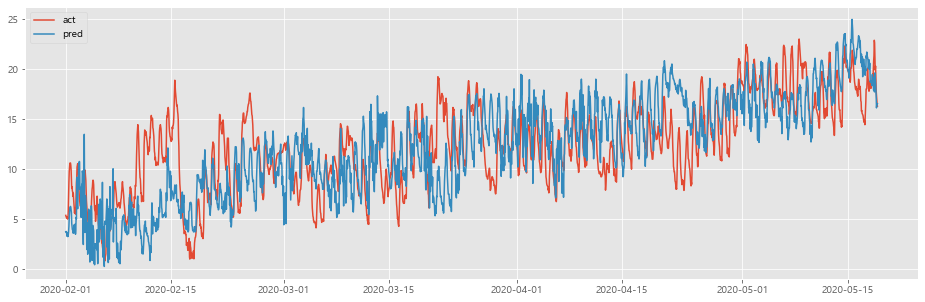

In [189]:
#temp_r_t_f = temp_r_t_f.set_index('datetime')
temp_r_t_f['pred'] = pred
plt.figure(figsize=(16,5))
plt.plot(temp_r_t_f['temp'])
plt.plot(temp_r_t_f['pred'])
plt.legend(['act','pred'])

#### temp_p_t

In [212]:
temp_p_t = temp_r_t_f['2020-02-07':'2020-03-05']
temp_p_t = temp_p_t[['pred']]
temp_p_t.rename(columns = {'pred':'temp'},inplace=True)
temp_p_t

,temp
datetime,
2020-02-07 00:00:00,4.271097
2020-02-07 01:00:00,4.730826
2020-02-07 02:00:00,5.103011
2020-02-07 03:00:00,5.091366
2020-02-07 04:00:00,5.981527
2020-02-07 05:00:00,5.483861
2020-02-07 06:00:00,9.467354
2020-02-07 07:00:00,10.041437
2020-02-07 08:00:00,2.711001


#### temp_p_d

In [213]:
temp_p_d = temp_groupby_date(temp_p_t)
temp_p_d

,temp_min,temp_max,temp_mean,temp_median,month,day_of_week,day_of_year,ytt,temp_min_diff_1,temp_min_diff_2,temp_min_diff_3,temp_max_diff_1,temp_max_diff_2,temp_max_diff_3,temp_mean_diff_1,temp_mean_diff_2,temp_mean_diff_3,temp_median_diff_1,temp_median_diff_2,temp_median_diff_3
datetime,,,,,,,,,,,,,,,,,,,,
2020-02-07,1.024458,10.041437,4.566702,4.807596,2,4,38,001,-0.490544,-0.981088,1.920662,-4.617179,-9.234358,-7.217207,-1.275776,-2.551552,-1.062403,-1.070246,-2.140493,-1.638785
2020-02-08,0.533915,5.424258,3.290926,3.737349,2,5,39,011,-0.490544,-0.981088,1.920662,-4.617179,-9.234358,-7.217207,-1.275776,-2.551552,-1.062403,-1.070246,-2.140493,-1.638785
2020-02-09,3.435664,7.441410,4.780076,4.239057,2,6,40,110,2.901749,2.411206,1.920662,2.017152,-2.600028,-7.217207,1.489150,0.213374,-1.062403,0.501707,-0.568539,-1.638785
2020-02-10,3.348279,7.301947,5.033138,4.875571,2,0,41,100,-0.087385,2.814364,2.323820,-0.139463,1.877689,-2.739490,0.253062,1.742212,0.466436,0.636514,1.138221,0.067975
2020-02-11,1.511262,4.800208,3.202798,3.337797,2,1,42,000,-1.837017,-1.924402,0.977348,-2.501739,-2.641202,-0.624050,-1.830340,-1.577278,-0.088128,-1.537773,-0.901260,-0.399552
2020-02-12,0.859715,6.625318,3.722280,4.306773,2,2,43,000,-0.651548,-2.488564,-2.575949,1.825110,-0.676630,-0.816092,0.519481,-1.310859,-1.057796,0.968975,-0.568798,0.067716
2020-02-13,3.751615,7.990308,5.585724,5.258073,2,3,44,000,2.891901,2.240353,0.403336,1.364990,3.190100,0.688361,1.863444,2.382925,0.552585,0.951300,1.920275,0.382502
2020-02-14,5.172931,12.124090,7.741356,7.428990,2,4,45,001,1.421315,4.313216,3.661668,4.133782,5.498772,7.323882,2.155632,4.019076,4.538558,2.170917,3.122217,4.091193
2020-02-15,6.314960,9.327085,7.529601,7.597172,2,5,46,011,1.142029,2.563345,5.455245,-2.797005,1.336777,2.701767,-0.211755,1.943877,3.807321,0.168182,2.339099,3.290399


__2018.02.01 ~ 2020.06.31 기온, 이슬점 예측 데이터__

In [16]:
temp_pd = pd.read_csv('data/SMP/pred_weather_all.csv',parse_dates=['date'])

temp_pd = pd.merge(temp_pd,time_data, left_on='date',right_on='datetime', how='left').set_index('datetime')

temp_pd = add_diff_columns(temp_pd, 'temp')
temp_pd = add_diff_columns(temp_pd, 'temp_min')
temp_pd = add_diff_columns(temp_pd, 'temp_max')

temp_pd = add_diff_columns(temp_pd, 'dew')
temp_pd = add_diff_columns(temp_pd, 'dew_min')
temp_pd = add_diff_columns(temp_pd, 'dew_max')

temp_pd.set_index('date',inplace=True)

temp_pd['2018-02-01':'2020-05-18']

temp_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2018-02-01 to 2020-06-30
Data columns (total 28 columns):
temp               881 non-null float64
temp_min           881 non-null float64
temp_max           881 non-null float64
dew                881 non-null float64
dew_min            881 non-null float64
dew_max            881 non-null float64
month              881 non-null category
day_of_week        881 non-null category
day_of_year        881 non-null category
ytt                881 non-null category
temp_diff_1        881 non-null float64
temp_diff_2        881 non-null float64
temp_diff_3        881 non-null float64
temp_min_diff_1    881 non-null float64
temp_min_diff_2    881 non-null float64
temp_min_diff_3    881 non-null float64
temp_max_diff_1    881 non-null float64
temp_max_diff_2    881 non-null float64
temp_max_diff_3    881 non-null float64
dew_diff_1         881 non-null float64
dew_diff_2         881 non-null float64
dew_diff_3         881 non-null 

#### temp_r_d

In [216]:
temp_r_t = temp_r_t['2020-02-07':'2020-03-05']
temp_r_t

,temp
datetime,
2020-02-07 00:00:00,4.375
2020-02-07 01:00:00,4.775
2020-02-07 02:00:00,4.775
2020-02-07 03:00:00,5.175
2020-02-07 04:00:00,5.250
2020-02-07 05:00:00,5.400
2020-02-07 06:00:00,5.475
2020-02-07 07:00:00,5.600
2020-02-07 08:00:00,5.850


In [217]:
temp_r_d = temp_groupby_date(temp_r_t)
temp_r_d

,temp_min,temp_max,temp_mean,temp_median,month,day_of_week,day_of_year,ytt,temp_min_diff_1,temp_min_diff_2,temp_min_diff_3,temp_max_diff_1,temp_max_diff_2,temp_max_diff_3,temp_mean_diff_1,temp_mean_diff_2,temp_mean_diff_3,temp_median_diff_1,temp_median_diff_2,temp_median_diff_3
datetime,,,,,,,,,,,,,,,,,,,,
2020-02-07,4.375,8.750,6.554167,6.3375,2,4,38,001,0.550,1.100000e+00,0.550,0.000,0.000,-5.250000e-01,0.290625,0.581250,-0.075000,0.3125,0.6250,0.3875
2020-02-08,4.925,8.750,6.844792,6.6500,2,5,39,011,0.550,1.100000e+00,0.550,0.000,0.000,-5.250000e-01,0.290625,0.581250,-0.075000,0.3125,0.6250,0.3875
2020-02-09,4.375,8.225,6.188542,6.4125,2,6,40,110,-0.550,0.000000e+00,0.550,-0.525,-0.525,-5.250000e-01,-0.656250,-0.365625,-0.075000,-0.2375,0.0750,0.3875
2020-02-10,6.100,14.450,10.012500,9.5000,2,0,41,100,1.725,1.175000e+00,1.725,6.225,5.700,5.700000e+00,3.823958,3.167708,3.458333,3.0875,2.8500,3.1625
2020-02-11,6.750,13.925,10.616667,11.9125,2,1,42,000,0.650,2.375000e+00,1.825,-0.525,5.700,5.175000e+00,0.604167,4.428125,3.771875,2.4125,5.5000,5.2625
2020-02-12,10.700,15.375,13.187500,13.2375,2,2,43,000,3.950,4.600000e+00,6.325,1.450,0.925,7.150000e+00,2.570833,3.175000,6.998958,1.3250,3.7375,6.8250
2020-02-13,10.375,14.450,11.921875,11.2875,2,3,44,000,-0.325,3.625000e+00,4.275,-0.925,0.525,-1.776357e-15,-1.265625,1.305208,1.909375,-1.9500,-0.6250,1.7875
2020-02-14,10.700,16.175,13.228125,13.2375,2,4,45,001,0.325,-1.776357e-15,3.950,1.725,0.800,2.250000e+00,1.306250,0.040625,2.611458,1.9500,0.0000,1.3250
2020-02-15,12.775,18.900,15.596875,15.6250,2,5,46,011,2.075,2.400000e+00,2.075,2.725,4.450,3.525000e+00,2.368750,3.675000,2.409375,2.3875,4.3375,2.3875


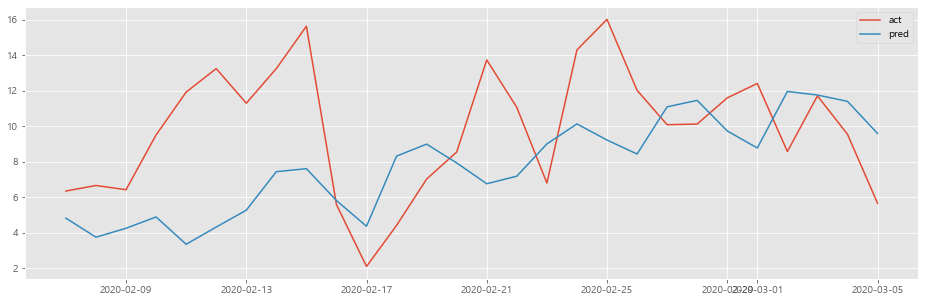

In [222]:
plt.figure(figsize=(16,5))
plt.plot(temp_r_d['temp_median'])
plt.plot(temp_p_d['temp_median'])
plt.legend(['act','pred'])

#### temp_p_d 로 smp_p_d 예측

__smp_min, smp_max, smp_mean, supply 예측 모델 생성 함수__

##### RandomForest

In [555]:
def smp_predict_model(temp,smp,target_col):

#temp = temp_i_d.copy()
#smp = smp_i_d.copy()
#target_col = 'smp_mean'

    X_data = temp
    y_target = smp[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=127)
    
    params = [{'n_estimators' : [10,50,100,400,800],
              'max_depth' : [6,8,10,12],
              'min_samples_leaf' : [6,8,12],
              'min_samples_split' : [4,8,16]
              }]

    rf_model = RandomForestRegressor()
    cv = KFold(n_splits=5, random_state=12)
    
    gscv = GridSearchCV(rf_model, params, cv=cv, scoring = 'neg_mean_squared_error')
    gscv.fit(X_train, y_train)
    best_rf_model = gscv.best_estimator_
    
    best_rf_model.fit(X_train,y_train)
    pred = best_rf_model.predict(X_test)
    print(target_col)
    evaluate_regr(y_test,pred)
    
    return best_rf_model

In [1695]:
def smp_predict_model(temp,smp,target_col):

#temp = temp_i_d.copy()
#smp = smp_i_d.copy()
#target_col = 'smp_mean'

    X_data = temp
    y_target = smp[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.1, random_state=3)
    
    rf_model = RandomForestRegressor(n_estimators = 1200, max_depth = 15)#, min_samples_leaf=10, min_samples_split=2,max_features=27)
    
    rf_model.fit(X_train,y_train)
    pred = rf_model.predict(X_test)
    print(target_col)
    evaluate_regr(y_test,pred)
    
    return rf_model

In [1696]:
pred_col = ['smp_min','smp_max','smp_mean','supply']
model_dict = {}

for col in pred_col :
    model_dict[col] = smp_predict_model(temp_pd_drop_dow['2018-02-01':'2020-05-18'], smp_i_d, col)

smp_min
MAE : 19.485, MSE : 589.407, RMSE : 24.278, RMSLE : 0.231
smp_max
MAE : 15.801, MSE : 472.350, RMSE : 21.734, RMSLE : 0.130
smp_mean
MAE : 12.544, MSE : 277.932, RMSE : 16.671, RMSLE : 0.120
supply
MAE : 2.028, MSE : 6.221, RMSE : 2.494, RMSLE : 0.034


__2020.02.07 ~ 2020.03.05 예측__

In [1697]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd_drop_dow['2020-02-07':'2020-03-05'])
    
pred_0203 = pd.DataFrame.from_dict(pred_dict)

In [1698]:
pred_0203['date'] = pd.date_range('2020-02-07','2020-03-05',freq='D')
#pred_0203.set_index('date',inplace=True)
pred_0203 = pred_0203[['date','smp_max','smp_min','smp_mean','supply']]
pred_0203

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,187.760797,94.176018,126.115057,84.340681
1,2020-02-08,155.171599,88.578475,106.911288,84.208299
2,2020-02-09,152.609800,85.336971,104.462043,83.300596
3,2020-02-10,169.496407,91.130519,119.540712,81.423784
4,2020-02-11,186.834301,91.745130,125.977462,77.127578
5,2020-02-12,183.807043,87.555882,112.870934,76.044220
6,2020-02-13,188.510109,87.771264,111.385363,74.095469
7,2020-02-14,186.724045,89.631536,109.207888,73.032409
8,2020-02-15,154.649026,93.632014,107.320062,66.563549
9,2020-02-16,134.510854,84.522592,96.404382,81.889585


__실제값과의 RMSE 확인__

In [1699]:
print(evaluate_regr(pred_0203['smp_max'],smp_i_d['2020-02-07':'2020-03-05']['smp_max']))
print(evaluate_regr(pred_0203['smp_min'],smp_i_d['2020-02-07':'2020-03-05']['smp_min']))
print(evaluate_regr(pred_0203['smp_mean'],smp_i_d['2020-02-07':'2020-03-05']['smp_mean']))
print(evaluate_regr(pred_0203['supply'],smp_i_d['2020-02-07':'2020-03-05']['supply']))

MAE : 10.315, MSE : 191.062, RMSE : 13.823, RMSLE : NAN
None
MAE : 8.573, MSE : 85.230, RMSE : 9.232, RMSLE : NAN
None
MAE : 7.434, MSE : 77.246, RMSE : 8.789, RMSLE : NAN
None
MAE : 0.811, MSE : 1.346, RMSE : 1.160, RMSLE : NAN
None


__2020.05.25 ~ 2020.06.21 예측__

In [58]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd['2020-05-25':'2020-06-21'])
    
pred_0506 = pd.DataFrame.from_dict(pred_dict)

In [62]:
pred_0506['date'] = pd.date_range('2020-05-25','2020-06-21',freq='D')
#pred_0506.set_index('date',inplace=True)
pred_0506 = pred_0506[['date','smp_max','smp_min','smp_mean','supply']]
pred_0506

,date,smp_max,smp_min,smp_mean,supply
0,2020-05-25,171.632031,124.668768,139.475974,64.887431
1,2020-05-26,171.387084,123.400610,139.721959,65.485697
2,2020-05-27,171.870453,124.922119,139.412490,65.615926
3,2020-05-28,170.508454,125.855769,139.697557,67.399605
4,2020-05-29,175.195209,118.932779,134.743605,64.620166
5,2020-05-30,176.532759,113.894328,134.216678,62.826378
6,2020-05-31,173.969052,124.465475,132.905308,62.490312
7,2020-06-01,175.381384,131.420518,137.086808,64.371174
8,2020-06-02,175.710738,133.880499,139.615560,66.494383
9,2020-06-03,182.885214,134.640748,145.362604,66.524295


__2020-02-07 ~ 2020-03-05, 2020-05-25 ~ 2020-06-21 병합__

In [900]:
pred_final = pd.concat([pred_0203,pred_0506])
pred_final.to_csv('pred_final1.csv',index=False)

##### XGBoost

In [86]:
temp_pd_xgb = pd.get_dummies(temp_pd, columns=['month','day_of_week','day_of_year','ytt'])

In [1955]:
temp_pd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2018-02-01 to 2020-06-30
Data columns (total 28 columns):
temp               881 non-null float64
temp_min           881 non-null float64
temp_max           881 non-null float64
dew                881 non-null float64
dew_min            881 non-null float64
dew_max            881 non-null float64
month              881 non-null category
day_of_week        881 non-null category
day_of_year        881 non-null category
ytt                881 non-null category
temp_diff_1        881 non-null float64
temp_diff_2        881 non-null float64
temp_diff_3        881 non-null float64
temp_min_diff_1    881 non-null float64
temp_min_diff_2    881 non-null float64
temp_min_diff_3    881 non-null float64
temp_max_diff_1    881 non-null float64
temp_max_diff_2    881 non-null float64
temp_max_diff_3    881 non-null float64
dew_diff_1         881 non-null float64
dew_diff_2         881 non-null float64
dew_diff_3         881 non-null 

In [1960]:
temp_pd_drop_dow = temp_pd.drop(['day_of_week'],axis=1)
temp_pd_drop_dow_xgb = pd.get_dummies(temp_pd_drop_dow, columns=['month','day_of_year','ytt'])

In [2032]:
def smp_predict_model(temp,smp,target_col):

#temp = temp_i_d.copy()
#smp = smp_i_d.copy()
#target_col = 'smp_mean'

    X_data = temp
    y_target = smp[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.001, random_state=3)
    
    xgb_model = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=12, gamma=4, nthread=4, subsample=0.8,min_child_weight=4)

    xgb_model.fit(X_train,y_train)
    pred = xgb_model.predict(X_test)
    print(target_col)
    evaluate_regr(y_test,pred)
    
    return xgb_model

In [2033]:
pred_col = ['smp_min','smp_max','smp_mean','supply']
model_dict = {}

for col in pred_col :
    model_dict[col] = smp_predict_model(temp_pd_drop_dow_xgb['2018-02-01':'2020-05-18'], smp_i_d, col)

[17:48:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smp_min
MAE : 8.346, MSE : 69.659, RMSE : 8.346, RMSLE : 0.072
[17:49:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smp_max
MAE : 28.212, MSE : 795.945, RMSE : 28.212, RMSLE : 0.168
[17:49:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smp_mean
MAE : 6.851, MSE : 46.935, RMSE : 6.851, RMSLE : 0.052
[17:50:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
supply
MAE : 0.462, MSE : 0.214, RMSE : 0.462, RMSLE : 0.006


__2020.02.07 ~ 2020.03.05 예측__

In [2034]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd_drop_dow_xgb['2020-02-07':'2020-03-05'])
    
pred_0203 = pd.DataFrame.from_dict(pred_dict)

In [2035]:
pred_0203['date'] = pd.date_range('2020-02-07','2020-03-05',freq='D')
#pred_0203.set_index('date',inplace=True)
pred_0203 = pred_0203[['date','smp_max','smp_min','smp_mean','supply']]
pred_0203

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,201.203476,84.626129,124.069359,84.379982
1,2020-02-08,152.083771,77.856110,94.611946,83.687180
2,2020-02-09,146.523926,75.003654,94.534187,82.605606
3,2020-02-10,174.038055,83.110931,113.891502,82.037476
4,2020-02-11,199.299240,85.165833,122.729088,76.845116
5,2020-02-12,196.941971,84.346199,109.943542,76.695274
6,2020-02-13,198.331528,84.902428,111.375473,74.256546
7,2020-02-14,201.309219,84.445145,104.222778,72.970985
8,2020-02-15,153.478912,84.346680,97.977303,66.566124
9,2020-02-16,132.640121,74.168793,85.283440,82.687981


In [2036]:
print(evaluate_regr(pred_0203['smp_max'],smp_i_d['2020-02-07':'2020-03-05']['smp_max']))
print(evaluate_regr(pred_0203['smp_min'],smp_i_d['2020-02-07':'2020-03-05']['smp_min']))
print(evaluate_regr(pred_0203['smp_mean'],smp_i_d['2020-02-07':'2020-03-05']['smp_mean']))
print(evaluate_regr(pred_0203['supply'],smp_i_d['2020-02-07':'2020-03-05']['supply']))

MAE : 0.470, MSE : 0.420, RMSE : 0.648, RMSLE : NAN
None
MAE : 0.404, MSE : 0.269, RMSE : 0.519, RMSLE : NAN
None
MAE : 0.582, MSE : 0.575, RMSE : 0.758, RMSLE : NAN
None
MAE : 0.407, MSE : 0.297, RMSE : 0.545, RMSLE : NAN
None


__2020.05.25 ~ 2020.06.21 예측__

In [2028]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd_drop_dow_xgb['2020-05-25':'2020-06-21'])
    
pred_0506 = pd.DataFrame.from_dict(pred_dict)

In [2029]:
pred_0506['date'] = pd.date_range('2020-05-25','2020-06-21',freq='D')
#pred_0506.set_index('date',inplace=True)
pred_0506 = pred_0506[['date','smp_max','smp_min','smp_mean','supply']]
pred_0506

,date,smp_max,smp_min,smp_mean,supply
0,2020-05-25,177.004242,126.141487,143.476318,64.559959
1,2020-05-26,178.790527,131.657669,147.141083,65.549927
2,2020-05-27,172.884933,130.648575,148.328522,65.797340
3,2020-05-28,172.278473,132.634644,148.526306,67.219231
4,2020-05-29,178.024521,117.588913,138.974991,65.316612
5,2020-05-30,182.018829,115.357948,135.254593,63.602695
6,2020-05-31,181.486252,130.959213,138.331741,62.414860
7,2020-06-01,184.935349,133.099609,148.997314,64.918602
8,2020-06-02,188.014618,132.815887,159.258728,65.933807
9,2020-06-03,190.710144,139.400009,155.383316,66.121109


__2020-02-07 ~ 2020-03-05, 2020-05-25 ~ 2020-06-21 병합__

In [2030]:
pred_final = pd.concat([pred_0203,pred_0506])
pred_final.to_csv('pred_final_xgb2_drop_dow9.csv',index=False)

##### light GBM


In [1679]:
def smp_predict_model(temp,smp,target_col):

#temp = temp_i_d.copy()
#smp = smp_i_d.copy()
#target_col = 'smp_mean'

    X_data = temp
    y_target = smp[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.1, random_state=3)
    
    train_ds = lgb.Dataset(X_train, label = y_train) 
    test_ds = lgb.Dataset(X_test, label = y_test) 
    
    params = {'learning_rate': 0.01, 
          'max_depth': 18, 
          'boosting': 'dart', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'is_training_metric': True, 
          #'num_leaves': 144, 
          'num_iterations' : 5000,
          'feature_fraction': 1, 
          'bagging_fraction': 1, 
          #'bagging_freq': 31, 
          #'max_bin':50,
          'scale_pos_weight':1.2, 
          'seed':2,
          }
    
    lgb_model = lgb.train(params, train_ds, 5000, test_ds, verbose_eval=600, early_stopping_rounds=100)

    #xgb_model.fit(X_train,y_train)
    pred = lgb_model.predict(X_test)
    print(target_col)
    evaluate_regr(y_test,pred)
    
    return lgb_model

In [1680]:
pred_col = ['smp_min','smp_max','smp_mean','supply']
model_dict = {}

for col in pred_col :
    model_dict[col] = smp_predict_model(temp_pd_drop_dow['2018-02-01':'2020-02-06'], smp_i_d['2018-02-01':'2020-02-06'], col)

[600]	valid_0's rmse: 41.6447
[1200]	valid_0's rmse: 24.4801
[1800]	valid_0's rmse: 20.5326
[2400]	valid_0's rmse: 20.2871
[3000]	valid_0's rmse: 19.4574
[3600]	valid_0's rmse: 19.4006
[4200]	valid_0's rmse: 19.1434
[4800]	valid_0's rmse: 19.1767
smp_min
MAE : 15.517, MSE : 364.792, RMSE : 19.100, RMSLE : 0.161
[600]	valid_0's rmse: 55.6085
[1200]	valid_0's rmse: 32.5786
[1800]	valid_0's rmse: 27.3069
[2400]	valid_0's rmse: 26.3528
[3000]	valid_0's rmse: 24.7496
[3600]	valid_0's rmse: 24.5347
[4200]	valid_0's rmse: 23.9618
[4800]	valid_0's rmse: 23.9795
smp_max
MAE : 18.213, MSE : 569.626, RMSE : 23.867, RMSLE : 0.137
[600]	valid_0's rmse: 44.7741
[1200]	valid_0's rmse: 23.7049
[1800]	valid_0's rmse: 18.1908
[2400]	valid_0's rmse: 17.2373
[3000]	valid_0's rmse: 15.8831
[3600]	valid_0's rmse: 15.7317
[4200]	valid_0's rmse: 15.0368
[4800]	valid_0's rmse: 14.9271
smp_mean
MAE : 11.392, MSE : 217.457, RMSE : 14.746, RMSLE : 0.105
[600]	valid_0's rmse: 22.5209
[1200]	valid_0's rmse: 11.1311

__2020.02.07 ~ 2020.03.05 예측__

In [1681]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd_drop_dow['2020-02-07':'2020-03-05'])
    
pred_0203 = pd.DataFrame.from_dict(pred_dict)

In [1682]:
pred_0203['date'] = pd.date_range('2020-02-07','2020-03-05',freq='D')
#pred_0203.set_index('date',inplace=True)
pred_0203 = pred_0203[['date','smp_max','smp_min','smp_mean','supply']]
pred_0203

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,166.465014,101.266685,138.945129,84.103138
1,2020-02-08,150.645020,119.750872,137.159028,81.514551
2,2020-02-09,169.975041,93.494332,135.350509,81.103685
3,2020-02-10,149.340426,111.585176,132.461798,75.189580
4,2020-02-11,164.786395,118.148066,134.427362,76.917659
5,2020-02-12,166.335761,100.825410,132.452140,72.242261
6,2020-02-13,173.791777,104.611608,123.754100,68.140859
7,2020-02-14,172.183354,117.428030,130.899349,68.881409
8,2020-02-15,156.540090,107.471999,130.121854,63.990221
9,2020-02-16,161.638472,116.160918,135.554581,78.471024


In [1683]:
print(evaluate_regr(pred_0203['smp_max'],smp_i_d['2020-02-07':'2020-03-05']['smp_max']))
print(evaluate_regr(pred_0203['smp_min'],smp_i_d['2020-02-07':'2020-03-05']['smp_min']))
print(evaluate_regr(pred_0203['smp_mean'],smp_i_d['2020-02-07':'2020-03-05']['smp_mean']))
print(evaluate_regr(pred_0203['supply'],smp_i_d['2020-02-07':'2020-03-05']['supply']))

MAE : 24.794, MSE : 985.376, RMSE : 31.391, RMSLE : NAN
None
MAE : 28.830, MSE : 967.439, RMSE : 31.104, RMSLE : NAN
None
MAE : 27.364, MSE : 982.169, RMSE : 31.340, RMSLE : NAN
None
MAE : 3.850, MSE : 20.736, RMSE : 4.554, RMSLE : NAN
None


__2020.05.25 ~ 2020.06.21 예측__

In [228]:
pred_dict = {}

for col,model in model_dict.items():
    pred_dict[col] = model.predict(temp_pd['2020-05-25':'2020-06-21'])
    
pred_0506 = pd.DataFrame.from_dict(pred_dict)

In [229]:
pred_0506['date'] = pd.date_range('2020-05-25','2020-06-21',freq='D')
#pred_0506.set_index('date',inplace=True)
pred_0506 = pred_0506[['date','smp_max','smp_min','smp_mean','supply']]
pred_0506

,date,smp_max,smp_min,smp_mean,supply
0,2020-05-25,173.508104,129.433174,148.610657,64.972071
1,2020-05-26,170.689971,134.658790,148.386855,65.807000
2,2020-05-27,176.016247,132.389319,149.753379,65.976012
3,2020-05-28,174.069458,132.134372,147.625795,68.255448
4,2020-05-29,176.308322,102.733082,134.316298,64.198950
5,2020-05-30,181.501358,96.610038,128.917237,63.413834
6,2020-05-31,173.700172,125.650664,133.782206,62.240115
7,2020-06-01,180.121744,136.015933,150.646752,64.405047
8,2020-06-02,183.651624,141.950915,159.187737,66.191755
9,2020-06-03,187.836394,144.440016,160.291187,66.015262


__2020-02-07 ~ 2020-03-05, 2020-05-25 ~ 2020-06-21 병합__

In [230]:
pred_final = pd.concat([pred_0203,pred_0506])
pred_final.to_csv('pred_final3.csv',index=False)

## 데이터 탐색

In [2048]:
pred_0506

,date,smp_max,smp_min,smp_mean,supply
0,2020-05-25,177.004242,126.141487,143.476318,64.559959
1,2020-05-26,178.790527,131.657669,147.141083,65.549927
2,2020-05-27,172.884933,130.648575,148.328522,65.797340
3,2020-05-28,172.278473,132.634644,148.526306,67.219231
4,2020-05-29,178.024521,117.588913,138.974991,65.316612
5,2020-05-30,182.018829,115.357948,135.254593,63.602695
6,2020-05-31,181.486252,130.959213,138.331741,62.414860
7,2020-06-01,184.935349,133.099609,148.997314,64.918602
8,2020-06-02,188.014618,132.815887,159.258728,65.933807
9,2020-06-03,190.710144,139.400009,155.383316,66.121109


In [2050]:
pred_total['date'] = pd.date_range('2018-02-01','2020-06-30',freq='D')
pred_total.set_index('date',inplace=True)
pred_total = pred_total[['smp_max','smp_min','smp_mean','supply']]
pred_total['2020-05-25':'2020-06-21']

,smp_max,smp_min,smp_mean,supply
date,,,,
2020-05-25,179.243881,130.992340,143.626785,64.864159
2020-05-26,180.702087,131.021439,148.350159,65.499565
2020-05-27,174.336121,127.876366,146.263794,65.622185
2020-05-28,175.188721,134.693146,151.424942,66.435745
2020-05-29,181.688507,117.137573,141.825333,65.253807
2020-05-30,178.535294,113.429230,133.760880,62.943150
2020-05-31,182.046555,128.266815,136.148148,62.516575
2020-06-01,184.139832,135.355942,153.255402,65.219734
2020-06-02,187.656631,140.433044,161.993210,66.177864


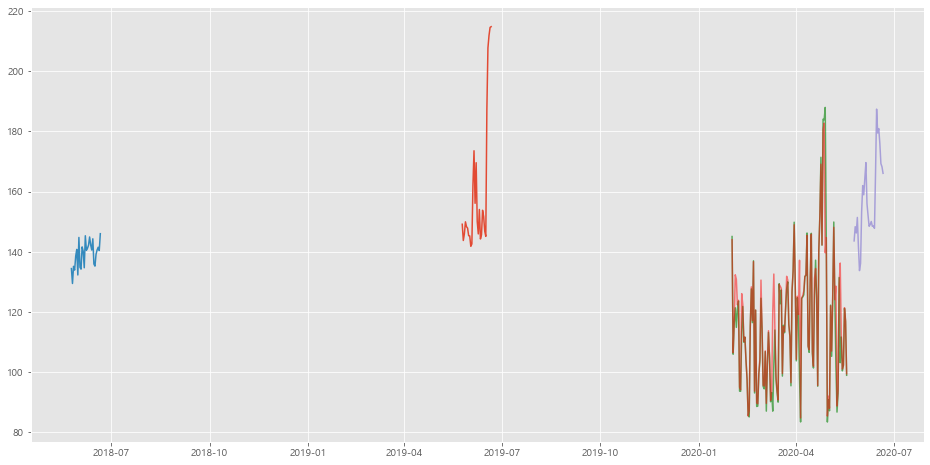

In [1439]:
plt.figure(figsize=(16,8))
plt.plot(smp_i_d['2019-05-25':'2019-06-21']['smp_mean'])
plt.plot(smp_i_d['2018-05-25':'2018-06-21']['smp_mean'])
plt.plot(smp_i_d['2020-02-01':'2020-05-18']['smp_mean'],color='g',alpha=0.6)
plt.plot(pred_total['2020-02-01':'2020-05-18']['smp_mean'],alpha=0.5,color='r')
plt.plot(pred_total['2020-05-25':'2020-06-21']['smp_mean'],alpha=0.8)
#plt.legend(['act','pred'])